####  Permanent Portfolio
* This notebook reproduces the charts in the blog article: [Retirement Portfolio-Permanent Flavor](http://appliedvalueinvestor.com/2017/08/22/retirement-portfolio-part-i/)

In [1]:
### Setup the environment
import os,sys
import pandas as pd
import pandas_datareader as web
import numpy as np
from datetime import datetime as dt
import matplotlib
import seaborn as sns
%matplotlib inline
import pylab as py
py.ion()

import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import warnings
warnings.filterwarnings('ignore')

file_path = os.path.dirname(os.path.realpath('__file__'))
sys_path='%s/..'%file_path
sys.path.append(sys_path)
from investmenttools import PortfolioBuilder as PB
reload(PB)

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
## Define python module to read ticker data from csv file downloaed from Yahoo-finance
def get_data_from_csv(filename,ticker):
	data=pd.read_csv(filename)
	data.set_index('Date',inplace=True)
	data.rename(columns={'Close':ticker},inplace=True)
	data=data[ticker]
	return data

In [3]:
## Get Portfolio
## It turns out that google only had historical data for ITOT from 2013 
## I Therefore had to download ITOT data from Yahoo Finance as a csv file

shy=get_data_from_csv('%s/../Data/SHY.csv'%file_path,'shy')
iau=get_data_from_csv('%s/../Data/IAU.csv'%file_path,'iau')
itot=get_data_from_csv('%s/../Data/ITOT.csv'%file_path,'itot')
tlt=get_data_from_csv('%s/../Data/TLT.csv'%file_path,'tlt')
portfolio=pd.concat([shy,iau,itot,tlt],axis=1)
portfolio.set_index(pd.to_datetime(portfolio.index),inplace=True) 
portfolio.dropna(inplace=True)
portfolio.rename(columns={'Close':'itot'},inplace=True)
portfolio.dropna(inplace=True)
portfolio_list=list(portfolio.columns)
print portfolio.head(5)

              shy    iau    itot    tlt
2005-05-02  80.92  4.297  25.580  92.09
2005-05-03  80.97  4.280  25.497  92.34
2005-05-04  81.00  4.294  25.853  91.53
2005-05-05  81.08  4.300  25.867  91.74
2005-05-06  80.90  4.259  25.785  91.06


         HP1      HP2
2005   7.001     7.34
2006   6.608     8.42
2007  11.055     4.38
2008  -1.230      2.3
2009   5.731     8.59
...      ...      ...
2012   4.138  -0.0151
2013  -4.137      2.4
2014   8.457     1.88
2015  -4.269 -0.00855
2016   4.276     5.65

[12 rows x 2 columns]


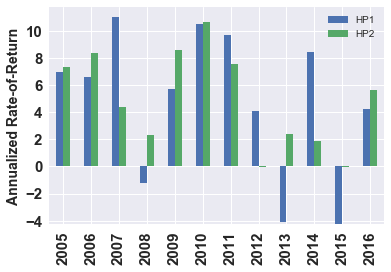

In [4]:
## Compute Annualized Returns for 1-Year and 2-Year holding period

Holding_Period=[1,2]
Years=np.arange(2005,2018)
portfolio_list=list(portfolio.columns)

Results=pd.DataFrame(columns=['HP1','HP2'],index=np.arange(len(Years)))

for duration in Holding_Period:
    Returns=[]
    for i in range(len(Years)-duration+1):
        val=PB.Backtest_Annual_Rebalance(portfolio_list,[.25,.25,.25,.25],\
                                         dt(Years[i],1,1),dt(Years[i]+duration-1,12,31),\
                                         initial=10000,stk_data=portfolio)
        rr=100*(((1+val['Total'].pct_change()).cumprod().iloc[-1])**(1./duration)-1)
        Returns.append(rr)
        #print Years[i]+duration-1,':',rr
    if duration==1:
        Results['HP1']=np.array(Returns)
    if duration==2:
        Returns.append(None)
        Results['HP2']=np.array(Returns)

Results.dropna(inplace=True)
Results.set_index(Years[0:-1],inplace=True)
print Results
_=Results.plot(kind='bar')
py.xticks(fontsize=15,fontweight='bold')
py.yticks(fontsize=15,fontweight='bold')
py.ylabel('Annualized Rate-of-Return',fontsize=14,fontweight='bold')


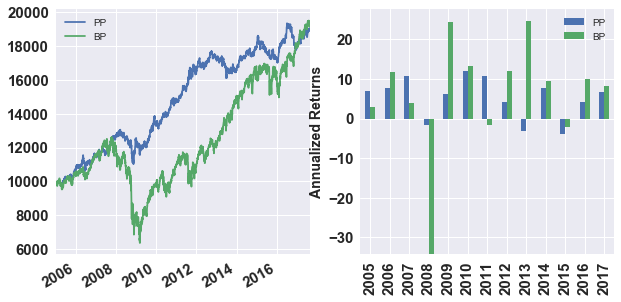

In [5]:
## Compare Buffet-Portfolio to PP:
## Holding Period: >12 years starting from 2005 through today, with annual
## rebalancing

bp_list=['shy','spy']
bp_weight=[.1,.9]
BP=PB.get_historical_closes(['shy','spy'],dt(2005,1,1),dt(2017,8,26))
BP.dropna(inplace=True)

PP_Growth=PB.Backtest_Annual_Rebalance(portfolio_list,[.25,.25,.25,.25],dt(2005,1,1),dt(2017,8,26),initial=10000,stk_data=portfolio)
BP_Growth=PB.Backtest_Annual_Rebalance(bp_list,bp_weight,dt(2005,1,1),dt(2017,8,26),initial=10000,stk_data=BP)

py.figure(figsize=(10,5))
ax1=py.subplot(121)
py.hold('on')
PP_Growth[['Total','Cash']].sum(axis=1).plot(ax=ax1)
BP_Growth[['Total','Cash']].sum(axis=1).plot(ax=ax1)
py.xticks(fontsize=15,fontweight='bold')
py.yticks(fontsize=15,fontweight='bold')
py.xlabel('')
py.legend(['PP','BP'],loc='best')

PP_dp=PB.calc_daily_returns(PP_Growth['Total'])
PP_ap=100*PB.calc_annual_returns(PP_dp)
PP_ap.name='PP'

BP_dp=PB.calc_daily_returns(BP_Growth['Total'])
BP_ap=100*PB.calc_annual_returns(BP_dp)
BP_ap.name='BP'

Compare=pd.concat([PP_ap,BP_ap],axis=1)
ax2=py.subplot(122)
Compare.plot(kind='bar',ax=ax2)
py.xticks(fontsize=15,fontweight='bold');
py.yticks(fontsize=15,fontweight='bold');
py.ylabel('Annualized Returns',fontweight='bold',fontsize=14)